In [8]:
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from dataset.MultiControlNetDataset import MultiControlNetDataset
from cldm.model import create_model, load_state_dict
from cldm.wandb_logger import WandbImageLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
from dotenv import dotenv_values
import torch

# Load the configuration file
with open('train_multi_pix2pix.yaml', 'r') as file:
    config = yaml.safe_load(file)


# Configs from YAML
resume_path = config['model']['control_net_path']
batch_size = config['training']['batch_size']
logger_freq = config['training']['logger_freq']
learning_rate = config['model']['learning_rate']
sd_locked = config['model']['sd_locked']
only_mid_control = config['model']['only_mid_control']
validation_ratio = config['dataset']['validation_ratio']
seed = config['training']['seed']

pl.seed_everything(seed, workers=True)

Seed set to 42


42

In [2]:
# Model Creation
model = create_model(config['model']['config_file']).cpu()
ls = load_state_dict(resume_path, location='cpu')

ExtendedControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, 

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.21.layer_norm2.bias', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.21.mlp.fc2.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'visio

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [4]:
ls['control_model.input_hint_block.0.weight']

tensor([[[[ 0.0734,  0.0777, -0.0025],
          [-0.0833,  0.1374,  0.1036],
          [-0.1372, -0.0985, -0.1368]],

         [[-0.0740, -0.1224,  0.0178],
          [ 0.1815,  0.1393, -0.0170],
          [ 0.1494,  0.0932,  0.1776]],

         [[ 0.1537,  0.1725,  0.0610],
          [ 0.0532, -0.0393,  0.1236],
          [ 0.0142, -0.0393, -0.0168]]],


        [[[-0.0351,  0.0550,  0.0297],
          [ 0.1267, -0.0915, -0.0136],
          [-0.0471,  0.1707,  0.0245]],

         [[-0.1464, -0.0395,  0.0640],
          [-0.0195,  0.0120,  0.0328],
          [ 0.0153,  0.1785, -0.0379]],

         [[-0.1125, -0.1249, -0.0869],
          [-0.0410, -0.1733,  0.0946],
          [-0.0583,  0.1446, -0.1722]]],


        [[[ 0.0268, -0.0054,  0.0982],
          [-0.1859, -0.0871, -0.0937],
          [-0.1147,  0.1399, -0.1123]],

         [[-0.0582,  0.0403,  0.0336],
          [-0.1736, -0.0468,  0.1027],
          [ 0.1714, -0.0082, -0.0749]],

         [[ 0.1914,  0.1724,  0.0328],
     

In [12]:
for item in ls['control_model.input_hint_block.0.weight']:
    
    item = item.repeat(1, 2, 1, 1).tolist()
    print(item)

[[[[0.07339917123317719, 0.0776689201593399, -0.002541676163673401], [-0.08333469182252884, 0.13741014897823334, 0.1035541445016861], [-0.13716310262680054, -0.09847313910722733, -0.1368045210838318]], [[-0.0739654079079628, -0.1224382296204567, 0.017807230353355408], [0.18152429163455963, 0.1392877846956253, -0.01703442633152008], [0.14935584366321564, 0.09323374927043915, 0.17757709324359894]], [[0.15371201932430267, 0.17247502505779266, 0.06104935705661774], [0.05324910581111908, -0.039347678422927856, 0.12364624440670013], [0.014240413904190063, -0.03932376205921173, -0.01676809787750244]], [[0.07339917123317719, 0.0776689201593399, -0.002541676163673401], [-0.08333469182252884, 0.13741014897823334, 0.1035541445016861], [-0.13716310262680054, -0.09847313910722733, -0.1368045210838318]], [[-0.0739654079079628, -0.1224382296204567, 0.017807230353355408], [0.18152429163455963, 0.1392877846956253, -0.01703442633152008], [0.14935584366321564, 0.09323374927043915, 0.17757709324359894]], 

In [13]:
repeated_tensor = torch.stack([torch.tensor(item).repeat(1, 2, 1, 1) for item in ls['control_model.input_hint_block.0.weight']])


/tmp/ipykernel_127216/838218907.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  repeated_tensor = torch.stack([torch.tensor(item).repeat(1, 2, 1, 1) for item in ls['control_model.input_hint_block.0.weight']])


In [16]:
repeated_tensor

<function Tensor.size>

In [1]:
import json
import cv2
import numpy as np
import os

from PIL import Image

In [2]:
img = cv2.imread(f'./test_imgs/bird.png')

In [17]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
len(img)

846

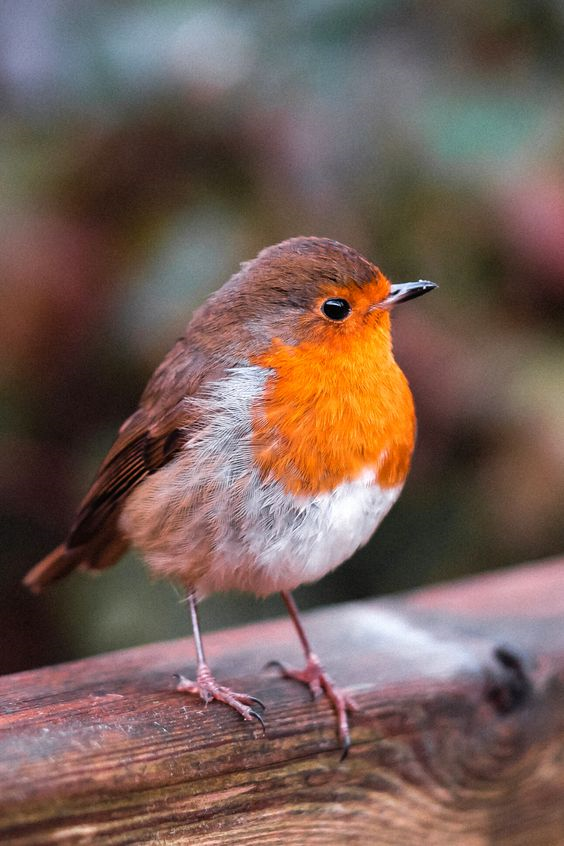

In [4]:
Image.fromarray(img)

In [6]:
from annotator.canny import CannyDetector
from annotator.util import resize_image, HWC3

In [13]:
apply_canny = CannyDetector()

detected_map = resize_image(HWC3(img), 512)
detected_map = apply_canny(img, 50, 250)
canny = HWC3(detected_map)

In [14]:
canny

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [18]:
len(canny)

846

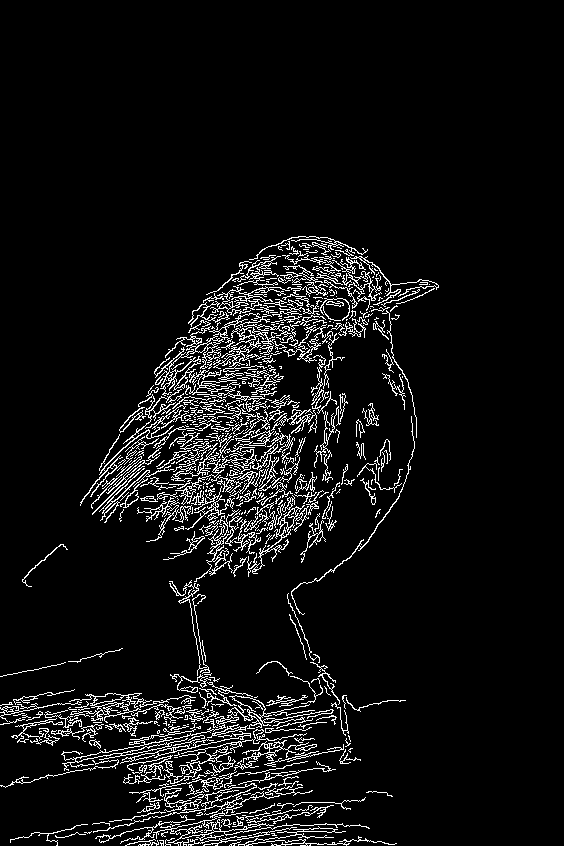

In [15]:
Image.fromarray(canny)